In [29]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u
from src.simulations.Rebound_v3 import OrbitalSimulation
from numpy.random import SeedSequence, Generator, PCG64
import src.utils.calculations as calc
import multiprocessing
import datetime
from numpy.random import SeedSequence, Generator, PCG64
import src.simulations.MonteCarlo_impsamp as MCi
import src.configurations.Configuration as conf
import src.analysis.Analysis as anl
import src.plotting.Plotting as pl
import datetime as dt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulation Runs

In [30]:
mPBH_grid = np.linspace(1.5e-7, 1e-4, 10) * const.M_sun.value  # from 1e-10 to 1 solar mass

In [34]:
run_dict = {}
for i, mPBH in enumerate(mPBH_grid):
    seed = i + 100  # Just a way to get different seeds
    name = f"Sun_Jupiter_s{seed}"
    configuration = conf.Configuration(name=name, seed=seed, importance_sampling=True)
    configuration.set_system_param('mC', mPBH)  # Mass of light PBH
    configuration.set_simulation_param('sample_size', 200)  # Mass of light PBH
    configuration.set_simulation_param('max_trials', 1000000000)  # Mass of light PBH
    max_v_default = configuration.get_simulation_param(all=True)['v_inf_grid'][-1]
    configuration.set_simulation_param('max_v', 0.9 * max_v_default)
    configuration.print_configuration()
    run_dict[name] = {'name': name, 'seed': seed, 'configuration': configuration}
    print(f"Prepared configuration for mPBH = {mPBH / const.M_sun.value} solar masses.\n")


Updated v_inf_grid_params 'max_v' to 36448.203227493854 and regenerated v_inf_grid.
System Parameters:
  mA: 1.988409870698051e+30
  mB: 1.8981245973360505e+27
  mC: 2.982614806047076e+23
  aB: 777908927640.0
  rB: 71492000.0
  vB: 13060.0
  eB: 0.0489
  iB: 0.02275909344600606
  epsilon: 0.1
  name: Sun_Jupiter_s100
  seed_base: 100

Simulation Parameters:
  trials: 10000000
  max_trials: 1000000000
  max_execution_time: 3600
  sample_size: 200
  max_e: 1.0
  vDM: 220000.0
  v_inf_grid_params: {'min_v': 1000, 'max_v': np.float64(36448.203227493854), 'n_v': 10}
  importance_sampling: True
  v_inf_grid: [ 1000.          4938.6892475   8877.378495   12816.0677425
 16754.75699    20693.4462375  24632.135485   28570.8247325
 32509.51397999 36448.20322749]
Prepared configuration for mPBH = 1.5e-07 solar masses.

Updated v_inf_grid_params 'max_v' to 36448.203227493854 and regenerated v_inf_grid.
System Parameters:
  mA: 1.988409870698051e+30
  mB: 1.8981245973360505e+27
  mC: 2.2358564323849

In [ ]:
def mc_worker(pars):
    conf, child_ss, v_inf = pars
    rng = Generator(PCG64(child_ss)) # independent per worker
    simulation = MCi.MonteCarloSimulation(conf, rng)
    return simulation.run_monte_carlo_simulation(v_inf)


for run in run_dict.values():
    now = datetime.datetime.now()
    print(f"Running simulation: {run['name']}")
    configuration_ = run['configuration']
    seed_ = run['seed']
    v_inf_grid_ = configuration_.get_simulation_param('v_inf_grid')
    if __name__ == "__main__":

        base_ss = SeedSequence(seed_)

        print(f'Starting {len(v_inf_grid_)} simulations with v_inf grid: {v_inf_grid_} km/s, simulation parameters: {configuration_.get_simulation_param(all=True)}')
        child_sss = base_ss.spawn(len(v_inf_grid_))
        pars = [(configuration_, child_sss[i], v_inf_grid_[i]) for i in range(len(v_inf_grid_))]
        # Create a pool of workers
        num_cores = len(v_inf_grid_)  # Get the number of available CPU cores
        with multiprocessing.Pool(processes=num_cores) as pool:
            # Distribute the simulations across the cores
            results = pool.map(mc_worker, pars)
        pool.close()
        pool.join()

        print(f'Execution time: {datetime.datetime.now() - now} for {len(v_inf_grid_)} simulations')
    print(f"Completed simulation: {run['name']} in {(datetime.datetime.now() - now).total_seconds()/60} minutes")


Running simulation: Sun_Jupiter_s100
Starting 10 simulations with v_inf grid: [ 1000.          4938.6892475   8877.378495   12816.0677425
 16754.75699    20693.4462375  24632.135485   28570.8247325
 32509.51397999 36448.20322749] km/s, simulation parameters: {'trials': 10000000, 'max_trials': 1000000000, 'max_execution_time': 3600, 'sample_size': 200, 'max_e': 1.0, 'vDM': 220000.0, 'v_inf_grid_params': {'min_v': 1000, 'max_v': np.float64(36448.203227493854), 'n_v': 10}, 'importance_sampling': True, 'v_inf_grid': array([ 1000.        ,  4938.6892475 ,  8877.378495  , 12816.0677425 ,
       16754.75699   , 20693.4462375 , 24632.135485  , 28570.8247325 ,
       32509.51397999, 36448.20322749])}


for v_inf=1.0 km/s MC capture cross-section: 5.010572121397137e+20 m^2
Number of captured orbits: 200
a (au): mean = 63.18625374559189 std = 28.97747869459315
e: mean = 0.9091306666945255 std = 0.07321438861230267
Results saved for v_inf=1.0 km/s with N=1585 trials.
for v_inf=4.938689247499316 km/s MC capture cross-section: 8.241756758420986e+19 m^2
Number of captured orbits: 200
a (au): mean = 49.85770191532456 std = 31.574772146178315
e: mean = 0.8722114714902418 std = 0.12402189372299892
Results saved for v_inf=4.938689247499316 km/s with N=9636 trials.


/data/a.saricaoglu/repo/captus/src/utils/calculations.py:644: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt(1 + (2*E2*L2**2)/(muA**2))
/data/a.saricaoglu/repo/captus/src/utils/calculations.py:644: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt(1 + (2*E2*L2**2)/(muA**2))
/data/a.saricaoglu/repo/captus/src/utils/calculations.py:644: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt(1 + (2*E2*L2**2)/(muA**2))


for v_inf=8.877378494998633 km/s MC capture cross-section: 9.581310699274277e+18 m^2
Number of captured orbits: 200
a (au): mean = 29.87222127168161 std = 26.891226516506922
e: mean = 0.7880468148119355 std = 0.17598881008156758
Results saved for v_inf=8.877378494998633 km/s with N=82888 trials.


/data/a.saricaoglu/repo/captus/src/utils/calculations.py:644: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt(1 + (2*E2*L2**2)/(muA**2))
/data/a.saricaoglu/repo/captus/src/utils/calculations.py:644: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt(1 + (2*E2*L2**2)/(muA**2))


for v_inf=12.816067742497951 km/s MC capture cross-section: 1.6448213697491192e+18 m^2
Number of captured orbits: 200
a (au): mean = 20.071270625155105 std = 20.812519336476164
e: mean = 0.7057370044757246 std = 0.22765564095189
Results saved for v_inf=12.816067742497951 km/s with N=482834 trials.
for v_inf=16.754756989997265 km/s MC capture cross-section: 4.7794919768122323e+17 m^2
Number of captured orbits: 200
a (au): mean = 15.37726608182786 std = 18.405446347041202
e: mean = 0.6605935350610845 std = 0.23603340217095595
Results saved for v_inf=16.754756989997265 km/s with N=1661632 trials.


In [4]:
conf_s1.print_preview()
v_inf_grid = conf_s1.get_simulation_param(all=True)['v_inf_grid']
seed = seed_s1
configuration_ = conf_s1

s = datetime.datetime.now()
# def mc_worker(pars):
#     conf, child_ss, v_inf = pars
#     rng = Generator(PCG64(child_ss)) # independent per worker
#     simulation = MCi.MonteCarloSimulation(conf, rng)
#     return simulation.run_monte_carlo_simulation(v_inf)

# if __name__ == "__main__":

#     base_ss = SeedSequence(seed)

#     print(f'Starting {len(v_inf_grid)} simulations with v_inf grid: {v_inf_grid} km/s, simulation parameters: {configuration_.get_simulation_param(all=True)}')
#     child_sss = base_ss.spawn(len(v_inf_grid))
#     pars = [(configuration_, child_sss[i], v_inf_grid[i]) for i in range(len(v_inf_grid))]
#     # Create a pool of workers
#     num_cores = len(v_inf_grid)  # Get the number of available CPU cores
#     with multiprocessing.Pool(processes=num_cores) as pool:
#         # Distribute the simulations across the cores
#         results = pool.map(mc_worker, pars)
#     pool.close()
#     pool.join()

#     print(f'Execution time: {datetime.datetime.now() - s} for {len(v_inf_grid)} simulations')

Configuration Preview:
  Name: Sun_Jupiter_s1
  Seed: 1
Orbital velocity of B: 13060.0 m/s
Escape velocity v_esc: 18471.681729576718 m/s
Maximum incoming velocity v_max: 40498.00358610428 m/s
Orbital period of B: 4329.08640202434 days
Semimajor axis of B: 5.199999999999999 au
Radius of B: 0.0004778945025452157 au
rClose: 0.23765280570179373 au
rHill: 0.33753896696786695 au
rClose/rHill: 0.7040751704511137
Radius of C: 2.961188614130705e-15 au


In [5]:
# mc_analysis_s1 = anl.Analysis(name=name_s1, configuration=conf_s1)
# sampled_mc_cat_s1 = mc_analysis_s1.get_sampled_mc_results()

In [6]:

# import os

# seed = seed_s1

# def check_result_exists(configuration, v_inf_kms, i, seed):
#     """Check if a result file already exists"""
#     v_str = f"{v_inf_kms:.0f}"
#     save_dir = configuration.get_save_dir_rebound()
#     dir_npz = os.path.join(save_dir, f"v{v_str}")
#     out_npz = os.path.join(dir_npz, f"sim_{i}_{seed}.npz")
#     return os.path.isfile(out_npz)

# def rebound_worker(pars):
#     configuration, child_ss, i, v_inf, lambda1, beta, phi, b, a_c, e_c = pars
#     rng = Generator(PCG64(child_ss))
#     simulation = OrbitalSimulation(configuration=configuration, rng=rng)
#     return simulation.run_orbital_integration(i, v_inf, lambda1, beta, phi, b, a_c, e_c, check_exists=False)

# if __name__ == "__main__":
#     s = datetime.datetime.now()
    
#     num_cores = 50
    
#     # Generate ALL seeds upfront based on total possible simulations
#     base_ss = SeedSequence(seed)
#     total_possible = np.sum([vdata['sampled_capture_count'] for vdata in sampled_mc_cat_s1.values()])
#     all_child_sss = base_ss.spawn(int(total_possible))  # Generate all seeds
    
#     # Now build parameter list, assigning correct seed to each simulation
#     pars = []
#     global_idx = 0  # Track position in all_child_sss
#     skipped = 0
    
#     for j, (v_key, vdata) in enumerate(sampled_mc_cat_s1.items()):
#         v_inf = vdata['v_inf']
#         v_inf_kms = v_inf / 1e3
#         lambda1 = vdata['lambda1']
#         beta = vdata['beta']
#         b = vdata['b']
#         phi = vdata['phi']
#         a_c = vdata['a_au']
#         e_c = vdata['e']
        
#         for i in range(vdata['sampled_capture_count']):
#             # Each simulation gets its designated seed from all_child_sss
#             if not check_result_exists(conf_s1, v_inf_kms, i, seed):
#                 pars.append((
#                     conf_s1,
#                     all_child_sss[global_idx],  # Correct seed based on global position
#                     i, v_inf, lambda1[i], beta[i], phi[i], b[i], a_c[i], e_c[i]
#                 ))
#             else:
#                 skipped += 1
            
#             global_idx += 1  # Increment regardless of whether we run or skip
    
#     total_to_run = len(pars)
#     print(f'Found {skipped} existing simulations (skipping)')
#     print(f'Running {total_to_run} missing simulations with {num_cores} cores')
    
#     if total_to_run == 0:
#         print('All simulations complete!')
#     else:
#         with multiprocessing.Pool(processes=min(num_cores, total_to_run)) as pool:
#             results = pool.map(rebound_worker, pars)
        
#         print(f'Execution time: {datetime.datetime.now() - s} for {total_to_run} simulations')

In [7]:
print('changed')
name_s2 = "Sun_Jupiter_s2"
seed_s2 = 2
conf_s2 = conf.Configuration(name=name_s2, seed=seed_s2, importance_sampling=True)
conf_s2.set_system_param('mC', mPBH_grid[1])  # Mass of light PBH
conf_s2.print_configuration()

conf_s2.print_preview()
v_inf_grid = conf_s2.get_simulation_param(all=True)['v_inf_grid']
seed = seed_s2
configuration_ = conf_s2

# s = datetime.datetime.now()
# def mc_worker(pars):
#     conf, child_ss, v_inf = pars
#     rng = Generator(PCG64(child_ss)) # independent per worker
#     simulation = MCi.MonteCarloSimulation(conf, rng)
#     return simulation.run_monte_carlo_simulation(v_inf)

# if __name__ == "__main__":

#     base_ss = SeedSequence(seed)

#     print(f'Starting {len(v_inf_grid)} simulations with v_inf grid: {v_inf_grid} km/s, simulation parameters: {configuration_.get_simulation_param(all=True)}')
#     child_sss = base_ss.spawn(len(v_inf_grid))
#     pars = [(configuration_, child_sss[i], v_inf_grid[i]) for i in range(len(v_inf_grid))]
#     # Create a pool of workers
#     num_cores = len(v_inf_grid)  # Get the number of available CPU cores
#     with multiprocessing.Pool(processes=num_cores) as pool:
#         # Distribute the simulations across the cores
#         results = pool.map(mc_worker, pars)
#     pool.close()
#     pool.join()

#     print(f'Execution time: {datetime.datetime.now() - s} for {len(v_inf_grid)} simulations')

# mc_analysis_s2 = anl.Analysis(name=name_s2, configuration=conf_s2)
# sampled_mc_cat_s2 = mc_analysis_s2.get_sampled_mc_results()

# if __name__ == "__main__":
#     s = datetime.datetime.now()
    
#     num_cores = 50
    
#     # Generate ALL seeds upfront based on total possible simulations
#     base_ss = SeedSequence(seed)
#     total_possible = np.sum([vdata['sampled_capture_count'] for vdata in sampled_mc_cat_s2.values()])
#     all_child_sss = base_ss.spawn(int(total_possible))  # Generate all seeds
    
#     # Now build parameter list, assigning correct seed to each simulation
#     pars = []
#     global_idx = 0  # Track position in all_child_sss
#     skipped = 0
    
#     for j, (v_key, vdata) in enumerate(sampled_mc_cat_s2.items()):
#         v_inf = vdata['v_inf']
#         v_inf_kms = v_inf / 1e3
#         lambda1 = vdata['lambda1']
#         beta = vdata['beta']
#         b = vdata['b']
#         phi = vdata['phi']
#         a_c = vdata['a_au']
#         e_c = vdata['e']
        
#         for i in range(vdata['sampled_capture_count']):
#             # Each simulation gets its designated seed from all_child_sss
#             if not check_result_exists(conf_s2, v_inf_kms, i, seed):
#                 pars.append((
#                     conf_s2,
#                     all_child_sss[global_idx],  # Correct seed based on global position
#                     i, v_inf, lambda1[i], beta[i], phi[i], b[i], a_c[i], e_c[i]
#                 ))
#             else:
#                 skipped += 1
            
#             global_idx += 1  # Increment regardless of whether we run or skip
    
#     total_to_run = len(pars)
#     print(f'Found {skipped} existing simulations (skipping)')
#     print(f'Running {total_to_run} missing simulations with {num_cores} cores')
    
#     if total_to_run == 0:
#         print('All simulations complete!')
#     else:
#         with multiprocessing.Pool(processes=min(num_cores, total_to_run)) as pool:
#             results = pool.map(rebound_worker, pars)
        
#         print(f'Execution time: {datetime.datetime.now() - s} for {total_to_run} simulations')
    

changed
System Parameters:
  mA: 1.988409870698051e+30
  mB: 1.8981245973360505e+27
  mC: 2.4744656168686856e+24
  aB: 777908927640.0
  rB: 71492000.0
  vB: 13060.0
  eB: 0.0489
  iB: 0.02275909344600606
  epsilon: 0.1
  name: Sun_Jupiter_s2
  seed_base: 2

Simulation Parameters:
  trials: 10000000
  max_trials: 100000000
  sample_size: 100
  max_e: 1.0
  vDM: 220000.0
  v_inf_grid: [ 1000.          5388.66706512  9777.33413025 14166.00119537
 18554.66826049 22943.33532561 27332.00239074 31720.66945586
 36109.33652098 40498.0035861 ]
  importance_sampling: True
Configuration Preview:
  Name: Sun_Jupiter_s2
  Seed: 2
Orbital velocity of B: 13060.0 m/s
Escape velocity v_esc: 18471.681729576718 m/s
Maximum incoming velocity v_max: 40498.00358610428 m/s
Orbital period of B: 4329.08640202434 days
Semimajor axis of B: 5.199999999999999 au
Radius of B: 0.0004778945025452157 au
rClose: 0.23765280570179373 au
rHill: 0.33753896696786695 au
rClose/rHill: 0.7040751704511137
Radius of C: 2.45668981

In [8]:
name_s3 = "Sun_Jupiter_s3"
seed_s3 = 3
conf_s3 = conf.Configuration(name=name_s3, seed=seed_s3, importance_sampling=True)
conf_s3.set_system_param('mC', mPBH_grid[2])  # Mass of light PBH
conf_s3.print_configuration()

conf_s3.print_preview()
v_inf_grid = conf_s3.get_simulation_param(all=True)['v_inf_grid']
seed = seed_s3
configuration_ = conf_s3

s = datetime.datetime.now()
# def mc_worker(pars):
#     conf, child_ss, v_inf = pars
#     rng = Generator(PCG64(child_ss)) # independent per worker
#     simulation = MCi.MonteCarloSimulation(conf, rng)
#     return simulation.run_monte_carlo_simulation(v_inf)

# if __name__ == "__main__":

#     base_ss = SeedSequence(seed)

#     print(f'Starting {len(v_inf_grid)} simulations with v_inf grid: {v_inf_grid} km/s, simulation parameters: {configuration_.get_simulation_param(all=True)}')
#     child_sss = base_ss.spawn(len(v_inf_grid))
#     pars = [(configuration_, child_sss[i], v_inf_grid[i]) for i in range(len(v_inf_grid))]
#     # Create a pool of workers
#     num_cores = len(v_inf_grid)  # Get the number of available CPU cores
#     with multiprocessing.Pool(processes=num_cores) as pool:
#         # Distribute the simulations across the cores
#         results = pool.map(mc_worker, pars)
#     pool.close()
#     pool.join()

#     print(f'Execution time: {datetime.datetime.now() - s} for {len(v_inf_grid)} simulations')

# mc_analysis_s3 = anl.Analysis(name=name_s3, configuration=conf_s3)
# sampled_mc_cat_s3 = mc_analysis_s3.get_sampled_mc_results()

# if __name__ == "__main__":
#     s = datetime.datetime.now()
    
#     num_cores = 50
    
#     # Generate ALL seeds upfront based on total possible simulations
#     base_ss = SeedSequence(seed)
#     total_possible = np.sum([vdata['sampled_capture_count'] for vdata in sampled_mc_cat_s3.values()])
#     all_child_sss = base_ss.spawn(int(total_possible))  # Generate all seeds
    
#     # Now build parameter list, assigning correct seed to each simulation
#     pars = []
#     global_idx = 0  # Track position in all_child_sss
#     skipped = 0
    
#     for j, (v_key, vdata) in enumerate(sampled_mc_cat_s3.items()):
#         v_inf = vdata['v_inf']
#         v_inf_kms = v_inf / 1e3
#         lambda1 = vdata['lambda1']
#         beta = vdata['beta']
#         b = vdata['b']
#         phi = vdata['phi']
#         a_c = vdata['a_au']
#         e_c = vdata['e']
        
#         for i in range(vdata['sampled_capture_count']):
#             # Each simulation gets its designated seed from all_child_sss
#             if not check_result_exists(conf_s3, v_inf_kms, i, seed):
#                 pars.append((
#                     conf_s3,
#                     all_child_sss[global_idx],  # Correct seed based on global position
#                     i, v_inf, lambda1[i], beta[i], phi[i], b[i], a_c[i], e_c[i]
#                 ))
#             else:
#                 skipped += 1
            
#             global_idx += 1  # Increment regardless of whether we run or skip
    
#     total_to_run = len(pars)
#     print(f'Found {skipped} existing simulations (skipping)')
#     print(f'Running {total_to_run} missing simulations with {num_cores} cores')
    
#     if total_to_run == 0:
#         print('All simulations complete!')
#     else:
#         with multiprocessing.Pool(processes=min(num_cores, total_to_run)) as pool:
#             results = pool.map(rebound_worker, pars)
        
#         print(f'Execution time: {datetime.datetime.now() - s} for {total_to_run} simulations')
    

System Parameters:
  mA: 1.988409870698051e+30
  mB: 1.8981245973360505e+27
  mC: 4.6506697531326634e+24
  aB: 777908927640.0
  rB: 71492000.0
  vB: 13060.0
  eB: 0.0489
  iB: 0.02275909344600606
  epsilon: 0.1
  name: Sun_Jupiter_s3
  seed_base: 3

Simulation Parameters:
  trials: 10000000
  max_trials: 100000000
  sample_size: 100
  max_e: 1.0
  vDM: 220000.0
  v_inf_grid: [ 1000.          5388.66706512  9777.33413025 14166.00119537
 18554.66826049 22943.33532561 27332.00239074 31720.66945586
 36109.33652098 40498.0035861 ]
  importance_sampling: True
Configuration Preview:
  Name: Sun_Jupiter_s3
  Seed: 3
Orbital velocity of B: 13060.0 m/s
Escape velocity v_esc: 18471.681729576718 m/s
Maximum incoming velocity v_max: 40498.00358610428 m/s
Orbital period of B: 4329.08640202434 days
Semimajor axis of B: 5.199999999999999 au
Radius of B: 0.0004778945025452157 au
rClose: 0.23765280570179373 au
rHill: 0.33753896696786695 au
rClose/rHill: 0.7040751704511137
Radius of C: 4.6172607649963955

In [9]:
name_s4 = "Sun_Jupiter_s4"
seed_s4 = 4
conf_s4 = conf.Configuration(name=name_s4, seed=seed_s4, importance_sampling=True)
conf_s4.set_system_param('mC', mPBH_grid[3])  # Mass of light PBH
conf_s4.print_configuration()

conf_s4.print_preview()
v_inf_grid = conf_s4.get_simulation_param(all=True)['v_inf_grid']
seed = seed_s4
configuration_ = conf_s4

s = datetime.datetime.now()
# def mc_worker(pars):
#     conf, child_ss, v_inf = pars
#     rng = Generator(PCG64(child_ss)) # independent per worker
#     simulation = MCi.MonteCarloSimulation(conf, rng)
#     return simulation.run_monte_carlo_simulation(v_inf)

# if __name__ == "__main__":

#     base_ss = SeedSequence(seed)

#     print(f'Starting {len(v_inf_grid)} simulations with v_inf grid: {v_inf_grid} km/s, simulation parameters: {configuration_.get_simulation_param(all=True)}')
#     child_sss = base_ss.spawn(len(v_inf_grid))
#     pars = [(configuration_, child_sss[i], v_inf_grid[i]) for i in range(len(v_inf_grid))]
#     # Create a pool of workers
#     num_cores = len(v_inf_grid)  # Get the number of available CPU cores
#     with multiprocessing.Pool(processes=num_cores) as pool:
#         # Distribute the simulations across the cores
#         results = pool.map(mc_worker, pars)
#     pool.close()
#     pool.join()

#     print(f'Execution time: {datetime.datetime.now() - s} for {len(v_inf_grid)} simulations')

# mc_analysis_s4 = anl.Analysis(name=name_s4, configuration=conf_s4)
# sampled_mc_cat_s4 = mc_analysis_s4.get_sampled_mc_results()

# if __name__ == "__main__":
#     s = datetime.datetime.now()
    
#     num_cores = 50
    
#     # Generate ALL seeds upfront based on total possible simulations
#     base_ss = SeedSequence(seed)
#     total_possible = np.sum([vdata['sampled_capture_count'] for vdata in sampled_mc_cat_s4.values()])
#     all_child_sss = base_ss.spawn(int(total_possible))  # Generate all seeds
    
#     # Now build parameter list, assigning correct seed to each simulation
#     pars = []
#     global_idx = 0  # Track position in all_child_sss
#     skipped = 0
    
#     for j, (v_key, vdata) in enumerate(sampled_mc_cat_s4.items()):
#         v_inf = vdata['v_inf']
#         v_inf_kms = v_inf / 1e3
#         lambda1 = vdata['lambda1']
#         beta = vdata['beta']
#         b = vdata['b']
#         phi = vdata['phi']
#         a_c = vdata['a_au']
#         e_c = vdata['e']
        
#         for i in range(vdata['sampled_capture_count']):
#             # Each simulation gets its designated seed from all_child_sss
#             if not check_result_exists(conf_s4, v_inf_kms, i, seed):
#                 pars.append((
#                     conf_s4,
#                     all_child_sss[global_idx],  # Correct seed based on global position
#                     i, v_inf, lambda1[i], beta[i], phi[i], b[i], a_c[i], e_c[i]
#                 ))
#             else:
#                 skipped += 1
            
#             global_idx += 1  # Increment regardless of whether we run or skip
    
#     total_to_run = len(pars)
#     print(f'Found {skipped} existing simulations (skipping)')
#     print(f'Running {total_to_run} missing simulations with {num_cores} cores')
    
#     if total_to_run == 0:
#         print('All simulations complete!')
#     else:
#         with multiprocessing.Pool(processes=min(num_cores, total_to_run)) as pool:
#             results = pool.map(rebound_worker, pars)
        
#         print(f'Execution time: {datetime.datetime.now() - s} for {total_to_run} simulations')
    

System Parameters:
  mA: 1.988409870698051e+30
  mB: 1.8981245973360505e+27
  mC: 6.826873889396642e+24
  aB: 777908927640.0
  rB: 71492000.0
  vB: 13060.0
  eB: 0.0489
  iB: 0.02275909344600606
  epsilon: 0.1
  name: Sun_Jupiter_s4
  seed_base: 4

Simulation Parameters:
  trials: 10000000
  max_trials: 100000000
  sample_size: 100
  max_e: 1.0
  vDM: 220000.0
  v_inf_grid: [ 1000.          5388.66706512  9777.33413025 14166.00119537
 18554.66826049 22943.33532561 27332.00239074 31720.66945586
 36109.33652098 40498.0035861 ]
  importance_sampling: True
Configuration Preview:
  Name: Sun_Jupiter_s4
  Seed: 4
Orbital velocity of B: 13060.0 m/s
Escape velocity v_esc: 18471.681729576718 m/s
Maximum incoming velocity v_max: 40498.00358610428 m/s
Orbital period of B: 4329.08640202434 days
Semimajor axis of B: 5.199999999999999 au
Radius of B: 0.0004778945025452157 au
rClose: 0.23765280570179373 au
rHill: 0.33753896696786695 au
rClose/rHill: 0.7040751704511137
Radius of C: 6.777831716788059e-

In [10]:
name_s5 = "Sun_Jupiter_s5"
seed_s5 = 5
conf_s5 = conf.Configuration(name=name_s5, seed=seed_s5, importance_sampling=True)
conf_s5.set_system_param('mC', mPBH_grid[4])  # Mass of light PBH
conf_s5.print_configuration()

conf_s5.print_preview()
v_inf_grid = conf_s5.get_simulation_param(all=True)['v_inf_grid']
seed = seed_s5
configuration_ = conf_s5

s = datetime.datetime.now()
# def mc_worker(pars):
#     conf, child_ss, v_inf = pars
#     rng = Generator(PCG64(child_ss)) # independent per worker
#     simulation = MCi.MonteCarloSimulation(conf, rng)
#     return simulation.run_monte_carlo_simulation(v_inf)

# if __name__ == "__main__":

#     base_ss = SeedSequence(seed)

#     print(f'Starting {len(v_inf_grid)} simulations with v_inf grid: {v_inf_grid} km/s, simulation parameters: {configuration_.get_simulation_param(all=True)}')
#     child_sss = base_ss.spawn(len(v_inf_grid))
#     pars = [(configuration_, child_sss[i], v_inf_grid[i]) for i in range(len(v_inf_grid))]
#     # Create a pool of workers
#     num_cores = len(v_inf_grid)  # Get the number of available CPU cores
#     with multiprocessing.Pool(processes=num_cores) as pool:
#         # Distribute the simulations across the cores
#         results = pool.map(mc_worker, pars)
#     pool.close()
#     pool.join()

#     print(f'Execution time: {datetime.datetime.now() - s} for {len(v_inf_grid)} simulations')

# mc_analysis_s5 = anl.Analysis(name=name_s5, configuration=conf_s5)
# sampled_mc_cat_s5 = mc_analysis_s5.get_sampled_mc_results()

# if __name__ == "__main__":
#     s = datetime.datetime.now()
    
#     num_cores = 50
    
#     # Generate ALL seeds upfront based on total possible simulations
#     base_ss = SeedSequence(seed)
#     total_possible = np.sum([vdata['sampled_capture_count'] for vdata in sampled_mc_cat_s5.values()])
#     all_child_sss = base_ss.spawn(int(total_possible))  # Generate all seeds
    
#     # Now build parameter list, assigning correct seed to each simulation
#     pars = []
#     global_idx = 0  # Track position in all_child_sss
#     skipped = 0
    
#     for j, (v_key, vdata) in enumerate(sampled_mc_cat_s5.items()):
#         v_inf = vdata['v_inf']
#         v_inf_kms = v_inf / 1e3
#         lambda1 = vdata['lambda1']
#         beta = vdata['beta']
#         b = vdata['b']
#         phi = vdata['phi']
#         a_c = vdata['a_au']
#         e_c = vdata['e']
        
#         for i in range(vdata['sampled_capture_count']):
#             # Each simulation gets its designated seed from all_child_sss
#             if not check_result_exists(conf_s5, v_inf_kms, i, seed):
#                 pars.append((
#                     conf_s5,
#                     all_child_sss[global_idx],  # Correct seed based on global position
#                     i, v_inf, lambda1[i], beta[i], phi[i], b[i], a_c[i], e_c[i]
#                 ))
#             else:
#                 skipped += 1
            
#             global_idx += 1  # Increment regardless of whether we run or skip
    
#     total_to_run = len(pars)
#     print(f'Found {skipped} existing simulations (skipping)')
#     print(f'Running {total_to_run} missing simulations with {num_cores} cores')
    
#     if total_to_run == 0:
#         print('All simulations complete!')
#     else:
#         with multiprocessing.Pool(processes=min(num_cores, total_to_run)) as pool:
#             results = pool.map(rebound_worker, pars)
        
#         print(f'Execution time: {datetime.datetime.now() - s} for {total_to_run} simulations')
    

System Parameters:
  mA: 1.988409870698051e+30
  mB: 1.8981245973360505e+27
  mC: 9.00307802566062e+24
  aB: 777908927640.0
  rB: 71492000.0
  vB: 13060.0
  eB: 0.0489
  iB: 0.02275909344600606
  epsilon: 0.1
  name: Sun_Jupiter_s5
  seed_base: 5

Simulation Parameters:
  trials: 10000000
  max_trials: 100000000
  sample_size: 100
  max_e: 1.0
  vDM: 220000.0
  v_inf_grid: [ 1000.          5388.66706512  9777.33413025 14166.00119537
 18554.66826049 22943.33532561 27332.00239074 31720.66945586
 36109.33652098 40498.0035861 ]
  importance_sampling: True
Configuration Preview:
  Name: Sun_Jupiter_s5
  Seed: 5
Orbital velocity of B: 13060.0 m/s
Escape velocity v_esc: 18471.681729576718 m/s
Maximum incoming velocity v_max: 40498.00358610428 m/s
Orbital period of B: 4329.08640202434 days
Semimajor axis of B: 5.199999999999999 au
Radius of B: 0.0004778945025452157 au
rClose: 0.23765280570179373 au
rHill: 0.33753896696786695 au
rClose/rHill: 0.7040751704511137
Radius of C: 8.938402668579723e-1

In [11]:
name_s6 = "Sun_Jupiter_s6"
seed_s6 = 6
conf_s6 = conf.Configuration(name=name_s6, seed=seed_s6, importance_sampling=True)
conf_s6.set_system_param('mC', mPBH_grid[5])  # Mass of light PBH
conf_s6.print_configuration()

conf_s6.print_preview()
v_inf_grid = conf_s6.get_simulation_param(all=True)['v_inf_grid']
seed = seed_s6
configuration_ = conf_s6

s = datetime.datetime.now()
# def mc_worker(pars):
#     conf, child_ss, v_inf = pars
#     rng = Generator(PCG64(child_ss)) # independent per worker
#     simulation = MCi.MonteCarloSimulation(conf, rng)
#     return simulation.run_monte_carlo_simulation(v_inf)

# if __name__ == "__main__":

#     base_ss = SeedSequence(seed)

#     print(f'Starting {len(v_inf_grid)} simulations with v_inf grid: {v_inf_grid} km/s, simulation parameters: {configuration_.get_simulation_param(all=True)}')
#     child_sss = base_ss.spawn(len(v_inf_grid))
#     pars = [(configuration_, child_sss[i], v_inf_grid[i]) for i in range(len(v_inf_grid))]
#     # Create a pool of workers
#     num_cores = len(v_inf_grid)  # Get the number of available CPU cores
#     with multiprocessing.Pool(processes=num_cores) as pool:
#         # Distribute the simulations across the cores
#         results = pool.map(mc_worker, pars)
#     pool.close()
#     pool.join()

#     print(f'Execution time: {datetime.datetime.now() - s} for {len(v_inf_grid)} simulations')

# mc_analysis_s6 = anl.Analysis(name=name_s6, configuration=conf_s6)
# sampled_mc_cat_s6 = mc_analysis_s6.get_sampled_mc_results()

# if __name__ == "__main__":
#     s = datetime.datetime.now()
    
#     num_cores = 50
    
#     # Generate ALL seeds upfront based on total possible simulations
#     base_ss = SeedSequence(seed)
#     total_possible = np.sum([vdata['sampled_capture_count'] for vdata in sampled_mc_cat_s6.values()])
#     all_child_sss = base_ss.spawn(int(total_possible))  # Generate all seeds
    
#     # Now build parameter list, assigning correct seed to each simulation
#     pars = []
#     global_idx = 0  # Track position in all_child_sss
#     skipped = 0
    
#     for j, (v_key, vdata) in enumerate(sampled_mc_cat_s6.items()):
#         v_inf = vdata['v_inf']
#         v_inf_kms = v_inf / 1e3
#         lambda1 = vdata['lambda1']
#         beta = vdata['beta']
#         b = vdata['b']
#         phi = vdata['phi']
#         a_c = vdata['a_au']
#         e_c = vdata['e']
        
#         for i in range(vdata['sampled_capture_count']):
#             # Each simulation gets its designated seed from all_child_sss
#             if not check_result_exists(conf_s6, v_inf_kms, i, seed):
#                 pars.append((
#                     conf_s6,
#                     all_child_sss[global_idx],  # Correct seed based on global position
#                     i, v_inf, lambda1[i], beta[i], phi[i], b[i], a_c[i], e_c[i]
#                 ))
#             else:
#                 skipped += 1
            
#             global_idx += 1  # Increment regardless of whether we run or skip
    
#     total_to_run = len(pars)
#     print(f'Found {skipped} existing simulations (skipping)')
#     print(f'Running {total_to_run} missing simulations with {num_cores} cores')
    
#     if total_to_run == 0:
#         print('All simulations complete!')
#     else:
#         with multiprocessing.Pool(processes=min(num_cores, total_to_run)) as pool:
#             results = pool.map(rebound_worker, pars)
        
#         print(f'Execution time: {datetime.datetime.now() - s} for {total_to_run} simulations')
    

System Parameters:
  mA: 1.988409870698051e+30
  mB: 1.8981245973360505e+27
  mC: 1.1179282161924599e+25
  aB: 777908927640.0
  rB: 71492000.0
  vB: 13060.0
  eB: 0.0489
  iB: 0.02275909344600606
  epsilon: 0.1
  name: Sun_Jupiter_s6
  seed_base: 6

Simulation Parameters:
  trials: 10000000
  max_trials: 100000000
  sample_size: 100
  max_e: 1.0
  vDM: 220000.0
  v_inf_grid: [ 1000.          5388.66706512  9777.33413025 14166.00119537
 18554.66826049 22943.33532561 27332.00239074 31720.66945586
 36109.33652098 40498.0035861 ]
  importance_sampling: True
Configuration Preview:
  Name: Sun_Jupiter_s6
  Seed: 6
Orbital velocity of B: 13060.0 m/s
Escape velocity v_esc: 18471.681729576718 m/s
Maximum incoming velocity v_max: 40498.00358610428 m/s
Orbital period of B: 4329.08640202434 days
Semimajor axis of B: 5.199999999999999 au
Radius of B: 0.0004778945025452157 au
rClose: 0.23765280570179373 au
rHill: 0.33753896696786695 au
rClose/rHill: 0.7040751704511137
Radius of C: 1.1098973620371384

In [12]:
name_s7 = "Sun_Jupiter_s7"
seed_s7 = 7
conf_s7 = conf.Configuration(name=name_s7, seed=seed_s7, importance_sampling=True)
conf_s7.set_system_param('mC', mPBH_grid[6])  # Mass of light PBH
conf_s7.print_configuration()

conf_s7.print_preview()
v_inf_grid = conf_s7.get_simulation_param(all=True)['v_inf_grid']
seed = seed_s7
configuration_ = conf_s7

s = datetime.datetime.now()
# def mc_worker(pars):
#     conf, child_ss, v_inf = pars
#     rng = Generator(PCG64(child_ss)) # independent per worker
#     simulation = MCi.MonteCarloSimulation(conf, rng)
#     return simulation.run_monte_carlo_simulation(v_inf)

# if __name__ == "__main__":

#     base_ss = SeedSequence(seed)

#     print(f'Starting {len(v_inf_grid)} simulations with v_inf grid: {v_inf_grid} km/s, simulation parameters: {configuration_.get_simulation_param(all=True)}')
#     child_sss = base_ss.spawn(len(v_inf_grid))
#     pars = [(configuration_, child_sss[i], v_inf_grid[i]) for i in range(len(v_inf_grid))]
#     # Create a pool of workers
#     num_cores = len(v_inf_grid)  # Get the number of available CPU cores
#     with multiprocessing.Pool(processes=num_cores) as pool:
#         # Distribute the simulations across the cores
#         results = pool.map(mc_worker, pars)
#     pool.close()
#     pool.join()

#     print(f'Execution time: {datetime.datetime.now() - s} for {len(v_inf_grid)} simulations')

# mc_analysis_s7 = anl.Analysis(name=name_s7, configuration=conf_s7)
# sampled_mc_cat_s7 = mc_analysis_s7.get_sampled_mc_results()

# if __name__ == "__main__":
#     s = datetime.datetime.now()
    
#     num_cores = 50
    
#     # Generate ALL seeds upfront based on total possible simulations
#     base_ss = SeedSequence(seed)
#     total_possible = np.sum([vdata['sampled_capture_count'] for vdata in sampled_mc_cat_s7.values()])
#     all_child_sss = base_ss.spawn(int(total_possible))  # Generate all seeds
    
#     # Now build parameter list, assigning correct seed to each simulation
#     pars = []
#     global_idx = 0  # Track position in all_child_sss
#     skipped = 0
    
#     for j, (v_key, vdata) in enumerate(sampled_mc_cat_s7.items()):
#         v_inf = vdata['v_inf']
#         v_inf_kms = v_inf / 1e3
#         lambda1 = vdata['lambda1']
#         beta = vdata['beta']
#         b = vdata['b']
#         phi = vdata['phi']
#         a_c = vdata['a_au']
#         e_c = vdata['e']
        
#         for i in range(vdata['sampled_capture_count']):
#             # Each simulation gets its designated seed from all_child_sss
#             if not check_result_exists(conf_s7, v_inf_kms, i, seed):
#                 pars.append((
#                     conf_s7,
#                     all_child_sss[global_idx],  # Correct seed based on global position
#                     i, v_inf, lambda1[i], beta[i], phi[i], b[i], a_c[i], e_c[i]
#                 ))
#             else:
#                 skipped += 1
            
#             global_idx += 1  # Increment regardless of whether we run or skip
    
#     total_to_run = len(pars)
#     print(f'Found {skipped} existing simulations (skipping)')
#     print(f'Running {total_to_run} missing simulations with {num_cores} cores')
    
#     if total_to_run == 0:
#         print('All simulations complete!')
#     else:
#         with multiprocessing.Pool(processes=min(num_cores, total_to_run)) as pool:
#             results = pool.map(rebound_worker, pars)
        
#         print(f'Execution time: {datetime.datetime.now() - s} for {total_to_run} simulations')
    

System Parameters:
  mA: 1.988409870698051e+30
  mB: 1.8981245973360505e+27
  mC: 1.3355486298188577e+25
  aB: 777908927640.0
  rB: 71492000.0
  vB: 13060.0
  eB: 0.0489
  iB: 0.02275909344600606
  epsilon: 0.1
  name: Sun_Jupiter_s7
  seed_base: 7

Simulation Parameters:
  trials: 10000000
  max_trials: 100000000
  sample_size: 100
  max_e: 1.0
  vDM: 220000.0
  v_inf_grid: [ 1000.          5388.66706512  9777.33413025 14166.00119537
 18554.66826049 22943.33532561 27332.00239074 31720.66945586
 36109.33652098 40498.0035861 ]
  importance_sampling: True
Configuration Preview:
  Name: Sun_Jupiter_s7
  Seed: 7
Orbital velocity of B: 13060.0 m/s
Escape velocity v_esc: 18471.681729576718 m/s
Maximum incoming velocity v_max: 40498.00358610428 m/s
Orbital period of B: 4329.08640202434 days
Semimajor axis of B: 5.199999999999999 au
Radius of B: 0.0004778945025452157 au
rClose: 0.23765280570179373 au
rHill: 0.33753896696786695 au
rClose/rHill: 0.7040751704511137
Radius of C: 1.3259544572163048

In [13]:
name_s8 = "Sun_Jupiter_s8"
seed_s8 = 8
conf_s8 = conf.Configuration(name=name_s8, seed=seed_s8, importance_sampling=True)
conf_s8.set_system_param('mC', mPBH_grid[7])  # Mass of light PBH
conf_s8.print_configuration()

conf_s8.print_preview()
v_inf_grid = conf_s8.get_simulation_param(all=True)['v_inf_grid']
seed = seed_s8
configuration_ = conf_s8

s = datetime.datetime.now()
# def mc_worker(pars):
#     conf, child_ss, v_inf = pars
#     rng = Generator(PCG64(child_ss)) # independent per worker
#     simulation = MCi.MonteCarloSimulation(conf, rng)
#     return simulation.run_monte_carlo_simulation(v_inf)

# if __name__ == "__main__":

#     base_ss = SeedSequence(seed)

#     print(f'Starting {len(v_inf_grid)} simulations with v_inf grid: {v_inf_grid} km/s, simulation parameters: {configuration_.get_simulation_param(all=True)}')
#     child_sss = base_ss.spawn(len(v_inf_grid))
#     pars = [(configuration_, child_sss[i], v_inf_grid[i]) for i in range(len(v_inf_grid))]
#     # Create a pool of workers
#     num_cores = len(v_inf_grid)  # Get the number of available CPU cores
#     with multiprocessing.Pool(processes=num_cores) as pool:
#         # Distribute the simulations across the cores
#         results = pool.map(mc_worker, pars)
#     pool.close()
#     pool.join()

#     print(f'Execution time: {datetime.datetime.now() - s} for {len(v_inf_grid)} simulations')

# mc_analysis_s8 = anl.Analysis(name=name_s8, configuration=conf_s8)
# sampled_mc_cat_s8 = mc_analysis_s8.get_sampled_mc_results()

# if __name__ == "__main__":
#     s = datetime.datetime.now()
    
#     num_cores = 50
    
#     # Generate ALL seeds upfront based on total possible simulations
#     base_ss = SeedSequence(seed)
#     total_possible = np.sum([vdata['sampled_capture_count'] for vdata in sampled_mc_cat_s8.values()])
#     all_child_sss = base_ss.spawn(int(total_possible))  # Generate all seeds
    
#     # Now build parameter list, assigning correct seed to each simulation
#     pars = []
#     global_idx = 0  # Track position in all_child_sss
#     skipped = 0
    
#     for j, (v_key, vdata) in enumerate(sampled_mc_cat_s8.items()):
#         v_inf = vdata['v_inf']
#         v_inf_kms = v_inf / 1e3
#         lambda1 = vdata['lambda1']
#         beta = vdata['beta']
#         b = vdata['b']
#         phi = vdata['phi']
#         a_c = vdata['a_au']
#         e_c = vdata['e']
        
#         for i in range(vdata['sampled_capture_count']):
#             # Each simulation gets its designated seed from all_child_sss
#             if not check_result_exists(conf_s8, v_inf_kms, i, seed):
#                 pars.append((
#                     conf_s8,
#                     all_child_sss[global_idx],  # Correct seed based on global position
#                     i, v_inf, lambda1[i], beta[i], phi[i], b[i], a_c[i], e_c[i]
#                 ))
#             else:
#                 skipped += 1
            
#             global_idx += 1  # Increment regardless of whether we run or skip
    
#     total_to_run = len(pars)
#     print(f'Found {skipped} existing simulations (skipping)')
#     print(f'Running {total_to_run} missing simulations with {num_cores} cores')
    
#     if total_to_run == 0:
#         print('All simulations complete!')
#     else:
#         with multiprocessing.Pool(processes=min(num_cores, total_to_run)) as pool:
#             results = pool.map(rebound_worker, pars)
        
#         print(f'Execution time: {datetime.datetime.now() - s} for {total_to_run} simulations')
    

System Parameters:
  mA: 1.988409870698051e+30
  mB: 1.8981245973360505e+27
  mC: 1.5531690434452553e+25
  aB: 777908927640.0
  rB: 71492000.0
  vB: 13060.0
  eB: 0.0489
  iB: 0.02275909344600606
  epsilon: 0.1
  name: Sun_Jupiter_s8
  seed_base: 8

Simulation Parameters:
  trials: 10000000
  max_trials: 100000000
  sample_size: 100
  max_e: 1.0
  vDM: 220000.0
  v_inf_grid: [ 1000.          5388.66706512  9777.33413025 14166.00119537
 18554.66826049 22943.33532561 27332.00239074 31720.66945586
 36109.33652098 40498.0035861 ]
  importance_sampling: True
Configuration Preview:
  Name: Sun_Jupiter_s8
  Seed: 8
Orbital velocity of B: 13060.0 m/s
Escape velocity v_esc: 18471.681729576718 m/s
Maximum incoming velocity v_max: 40498.00358610428 m/s
Orbital period of B: 4329.08640202434 days
Semimajor axis of B: 5.199999999999999 au
Radius of B: 0.0004778945025452157 au
rClose: 0.23765280570179373 au
rHill: 0.33753896696786695 au
rClose/rHill: 0.7040751704511137
Radius of C: 1.5420115523954708

In [14]:
name_s9 = "Sun_Jupiter_s9"
seed_s9 = 9
conf_s9 = conf.Configuration(name=name_s9, seed=seed_s9, importance_sampling=True)
conf_s9.set_system_param('mC', mPBH_grid[8])  # Mass of light PBH
conf_s9.print_configuration()

conf_s9.print_preview()
v_inf_grid = conf_s9.get_simulation_param(all=True)['v_inf_grid']
seed = seed_s9
configuration_ = conf_s9

s = datetime.datetime.now()
# def mc_worker(pars):
#     conf, child_ss, v_inf = pars
#     rng = Generator(PCG64(child_ss)) # independent per worker
#     simulation = MCi.MonteCarloSimulation(conf, rng)
#     return simulation.run_monte_carlo_simulation(v_inf)

# if __name__ == "__main__":

#     base_ss = SeedSequence(seed)

#     print(f'Starting {len(v_inf_grid)} simulations with v_inf grid: {v_inf_grid} km/s, simulation parameters: {configuration_.get_simulation_param(all=True)}')
#     child_sss = base_ss.spawn(len(v_inf_grid))
#     pars = [(configuration_, child_sss[i], v_inf_grid[i]) for i in range(len(v_inf_grid))]
#     # Create a pool of workers
#     num_cores = len(v_inf_grid)  # Get the number of available CPU cores
#     with multiprocessing.Pool(processes=num_cores) as pool:
#         # Distribute the simulations across the cores
#         results = pool.map(mc_worker, pars)
#     pool.close()
#     pool.join()

#     print(f'Execution time: {datetime.datetime.now() - s} for {len(v_inf_grid)} simulations')

# mc_analysis_s9 = anl.Analysis(name=name_s9, configuration=conf_s9)
# sampled_mc_cat_s9 = mc_analysis_s9.get_sampled_mc_results()

# if __name__ == "__main__":
#     s = datetime.datetime.now()
    
#     num_cores = 50
    
#     # Generate ALL seeds upfront based on total possible simulations
#     base_ss = SeedSequence(seed)
#     total_possible = np.sum([vdata['sampled_capture_count'] for vdata in sampled_mc_cat_s9.values()])
#     all_child_sss = base_ss.spawn(int(total_possible))  # Generate all seeds
    
#     # Now build parameter list, assigning correct seed to each simulation
#     pars = []
#     global_idx = 0  # Track position in all_child_sss
#     skipped = 0

#     for j, (v_key, vdata) in enumerate(sampled_mc_cat_s9.items()):
#         v_inf = vdata['v_inf']
#         v_inf_kms = v_inf / 1e3
#         lambda1 = vdata['lambda1']
#         beta = vdata['beta']
#         b = vdata['b']
#         phi = vdata['phi']
#         a_c = vdata['a_au']
#         e_c = vdata['e']
        
#         for i in range(vdata['sampled_capture_count']):
#             # Each simulation gets its designated seed from all_child_sss
#             if not check_result_exists(conf_s9, v_inf_kms, i, seed):
#                 pars.append((
#                     conf_s9,
#                     all_child_sss[global_idx],  # Correct seed based on global position
#                     i, v_inf, lambda1[i], beta[i], phi[i], b[i], a_c[i], e_c[i]
#                 ))
#             else:
#                 skipped += 1
            
#             global_idx += 1  # Increment regardless of whether we run or skip
    
#     total_to_run = len(pars)
#     print(f'Found {skipped} existing simulations (skipping)')
#     print(f'Running {total_to_run} missing simulations with {num_cores} cores')
    
#     if total_to_run == 0:
#         print('All simulations complete!')
#     else:
#         with multiprocessing.Pool(processes=min(num_cores, total_to_run)) as pool:
#             results = pool.map(rebound_worker, pars)
        
#         print(f'Execution time: {datetime.datetime.now() - s} for {total_to_run} simulations')
    

System Parameters:
  mA: 1.988409870698051e+30
  mB: 1.8981245973360505e+27
  mC: 1.7707894570716532e+25
  aB: 777908927640.0
  rB: 71492000.0
  vB: 13060.0
  eB: 0.0489
  iB: 0.02275909344600606
  epsilon: 0.1
  name: Sun_Jupiter_s9
  seed_base: 9

Simulation Parameters:
  trials: 10000000
  max_trials: 100000000
  sample_size: 100
  max_e: 1.0
  vDM: 220000.0
  v_inf_grid: [ 1000.          5388.66706512  9777.33413025 14166.00119537
 18554.66826049 22943.33532561 27332.00239074 31720.66945586
 36109.33652098 40498.0035861 ]
  importance_sampling: True
Configuration Preview:
  Name: Sun_Jupiter_s9
  Seed: 9
Orbital velocity of B: 13060.0 m/s
Escape velocity v_esc: 18471.681729576718 m/s
Maximum incoming velocity v_max: 40498.00358610428 m/s
Orbital period of B: 4329.08640202434 days
Semimajor axis of B: 5.199999999999999 au
Radius of B: 0.0004778945025452157 au
rClose: 0.23765280570179373 au
rHill: 0.33753896696786695 au
rClose/rHill: 0.7040751704511137
Radius of C: 1.758068647574637e

In [15]:
name_s10 = "Sun_Jupiter_s10"
seed_s10 = 10
conf_s10 = conf.Configuration(name=name_s10, seed=seed_s10, importance_sampling=True)
conf_s10.set_system_param('mC', mPBH_grid[9])  # Mass of light PBH
conf_s10.print_configuration()

conf_s10.print_preview()
v_inf_grid = conf_s10.get_simulation_param(all=True)['v_inf_grid']
seed = seed_s10
configuration_ = conf_s10

s = datetime.datetime.now()
# def mc_worker(pars):
#     conf, child_ss, v_inf = pars
#     rng = Generator(PCG64(child_ss)) # independent per worker
#     simulation = MCi.MonteCarloSimulation(conf, rng)
#     return simulation.run_monte_carlo_simulation(v_inf)

# if __name__ == "__main__":

#     base_ss = SeedSequence(seed)

#     print(f'Starting {len(v_inf_grid)} simulations with v_inf grid: {v_inf_grid} km/s, simulation parameters: {configuration_.get_simulation_param(all=True)}')
#     child_sss = base_ss.spawn(len(v_inf_grid))
#     pars = [(configuration_, child_sss[i], v_inf_grid[i]) for i in range(len(v_inf_grid))]
#     # Create a pool of workers
#     num_cores = len(v_inf_grid)  # Get the number of available CPU cores
#     with multiprocessing.Pool(processes=num_cores) as pool:
#         # Distribute the simulations across the cores
#         results = pool.map(mc_worker, pars)
#     pool.close()
#     pool.join()

#     print(f'Execution time: {datetime.datetime.now() - s} for {len(v_inf_grid)} simulations')

# mc_analysis_s10 = anl.Analysis(name=name_s10, configuration=conf_s10)
# sampled_mc_cat_s10 = mc_analysis_s10.get_sampled_mc_results()

# if __name__ == "__main__":
#     s = datetime.datetime.now()
    
#     num_cores = 50
    
#     # Generate ALL seeds upfront based on total possible simulations
#     base_ss = SeedSequence(seed)
#     total_possible = np.sum([vdata['sampled_capture_count'] for vdata in sampled_mc_cat_s10.values()])
#     all_child_sss = base_ss.spawn(int(total_possible))  # Generate all seeds
    
#     # Now build parameter list, assigning correct seed to each simulation
#     pars = []
#     global_idx = 0  # Track position in all_child_sss
#     skipped = 0
    
#     for j, (v_key, vdata) in enumerate(sampled_mc_cat_s10.items()):
#         v_inf = vdata['v_inf']
#         v_inf_kms = v_inf / 1e3
#         lambda1 = vdata['lambda1']
#         beta = vdata['beta']
#         b = vdata['b']
#         phi = vdata['phi']
#         a_c = vdata['a_au']
#         e_c = vdata['e']
        
#         for i in range(vdata['sampled_capture_count']):
#             # Each simulation gets its designated seed from all_child_sss
#             if not check_result_exists(conf_s10, v_inf_kms, i, seed):
#                 pars.append((
#                     conf_s10,
#                     all_child_sss[global_idx],  # Correct seed based on global position
#                     i, v_inf, lambda1[i], beta[i], phi[i], b[i], a_c[i], e_c[i]
#                 ))
#             else:
#                 skipped += 1
            
#             global_idx += 1  # Increment regardless of whether we run or skip
    
#     total_to_run = len(pars)
#     print(f'Found {skipped} existing simulations (skipping)')
#     print(f'Running {total_to_run} missing simulations with {num_cores} cores')
    
#     if total_to_run == 0:
#         print('All simulations complete!')
#     else:
#         with multiprocessing.Pool(processes=min(num_cores, total_to_run)) as pool:
#             results = pool.map(rebound_worker, pars)
        
#         print(f'Execution time: {datetime.datetime.now() - s} for {total_to_run} simulations')
    

System Parameters:
  mA: 1.988409870698051e+30
  mB: 1.8981245973360505e+27
  mC: 1.988409870698051e+25
  aB: 777908927640.0
  rB: 71492000.0
  vB: 13060.0
  eB: 0.0489
  iB: 0.02275909344600606
  epsilon: 0.1
  name: Sun_Jupiter_s10
  seed_base: 10

Simulation Parameters:
  trials: 10000000
  max_trials: 100000000
  sample_size: 100
  max_e: 1.0
  vDM: 220000.0
  v_inf_grid: [ 1000.          5388.66706512  9777.33413025 14166.00119537
 18554.66826049 22943.33532561 27332.00239074 31720.66945586
 36109.33652098 40498.0035861 ]
  importance_sampling: True
Configuration Preview:
  Name: Sun_Jupiter_s10
  Seed: 10
Orbital velocity of B: 13060.0 m/s
Escape velocity v_esc: 18471.681729576718 m/s
Maximum incoming velocity v_max: 40498.00358610428 m/s
Orbital period of B: 4329.08640202434 days
Semimajor axis of B: 5.199999999999999 au
Radius of B: 0.0004778945025452157 au
rClose: 0.23765280570179373 au
rHill: 0.33753896696786695 au
rClose/rHill: 0.7040751704511137
Radius of C: 1.9741257427538

In [96]:
runs_dict = {}
config_list = [conf_s1, conf_s2, conf_s3, conf_s4, conf_s5, conf_s6, conf_s7, conf_s8, conf_s9, conf_s10]
# 
# analysis_list = [mc_analysis_s1, mc_analysis_s2, mc_analysis_s3, mc_analysis_s4, mc_analysis_s5,
#                  mc_analysis_s6, mc_analysis_s7, mc_analysis_s8, mc_analysis_s9, mc_analysis_s10]
for i in range(len(config_list)):

    configuration = config_list[i]
    analysis = anl.Analysis(name=configuration.name, configuration=configuration)
    catalog = analysis.get_combined_dictionary()
    sampled_mc = analysis.get_sampled_mc_results()

    runs_dict[f'run_{i+1}'] = {
        'configuration': configuration,
        'analysis': analysis,
        'catalog': catalog,
        'sampled_mc': sampled_mc
    }

Loading MC results from: /data/a.saricaoglu/repo/captus/runs/Sun_Jupiter_s1/Monte_Carlo_Results/
Loading Rebound results from: /data/a.saricaoglu/repo/captus/runs/Sun_Jupiter_s1/Rebound_Simulation_Results/
captured objects for v_inf = v1 km/s: 100
v_inf = v1 km/s: sampled 100 captured objects
captured objects for v_inf = v5 km/s: 100
v_inf = v5 km/s: sampled 100 captured objects
captured objects for v_inf = v10 km/s: 100
v_inf = v10 km/s: sampled 100 captured objects
captured objects for v_inf = v14 km/s: 100
v_inf = v14 km/s: sampled 100 captured objects
captured objects for v_inf = v19 km/s: 100
v_inf = v19 km/s: sampled 100 captured objects
captured objects for v_inf = v23 km/s: 100
v_inf = v23 km/s: sampled 100 captured objects
captured objects for v_inf = v27 km/s: 100
v_inf = v27 km/s: sampled 100 captured objects
captured objects for v_inf = v32 km/s: 65
v_inf = v32 km/s: sampled 65 captured objects
captured objects for v_inf = v36 km/s: 1
v_inf = v36 km/s: sampled 1 captured ob

In [17]:
for run in runs_dict.keys():
    print(f"{run}:")
    analysis = runs_dict[run]['analysis']
    catalog = runs_dict[run]['catalog']
    analysis.print_detailed_catalog_summary()
    print("...............................")

run_1:
Velocity bin: v1, sampled capture count 100 total capture count: 100 out of 873 samples
v1 non-zero termination counts:
  escape_C_count: 97
  time_exceeded_count: 3
--------------------------------
Velocity bin: v5, sampled capture count 100 total capture count: 100 out of 6429 samples
v5 non-zero termination counts:
  escape_C_count: 99
  time_exceeded_count: 1
--------------------------------
Velocity bin: v10, sampled capture count 100 total capture count: 100 out of 70384 samples
v10 non-zero termination counts:
  escape_C_count: 97
  time_exceeded_count: 2
  completed_count: 1
--------------------------------
Velocity bin: v14, sampled capture count 100 total capture count: 100 out of 404276 samples
v14 non-zero termination counts:
  escape_C_count: 96
  collision_count_rebound: 2
  completed_count: 2
--------------------------------
Velocity bin: v19, sampled capture count 100 total capture count: 100 out of 1598889 samples
v19 non-zero termination counts:
  escape_C_coun

In [18]:
for run in runs_dict.keys():
    print(f"{run}:")
    analysis = runs_dict[run]['analysis']
    catalog = runs_dict[run]['catalog']
    print(catalog['total_occurrences_gl']['total_systems_neq_gl'])
    print("...............................")

run_1:
0.20231111383427727
...............................
run_2:
0.304285087203036
...............................
run_3:
0.2383245797155798
...............................
run_4:
0.31243007416525703
...............................
run_5:
0.336249505738962
...............................
run_6:
0.2887496625011131
...............................
run_7:
0.32505673680654745
...............................
run_8:
0.3390265448013129
...............................
run_9:
0.3398775229645537
...............................
run_10:
0.24758187517211963
...............................


In [19]:
print(catalog['total_occurrences_gl']['total_systems_neq_gl'])
print(catalog['total_occurrences_trapz']['total_systems_neq'])


0.24758187517211963
0.24446587463380032


/data/a.saricaoglu/repo/captus/src/plotting/Plotting.py:220: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(frameon=False, loc='upper center', ncol=2)


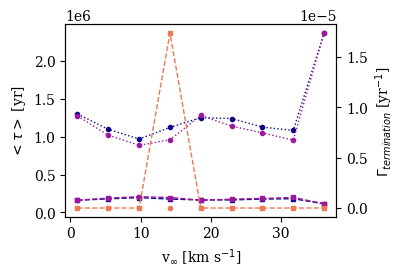

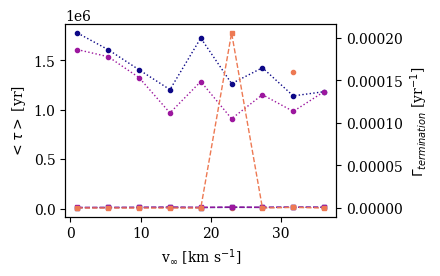

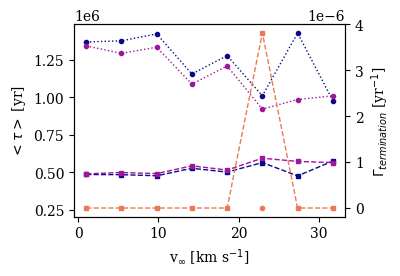

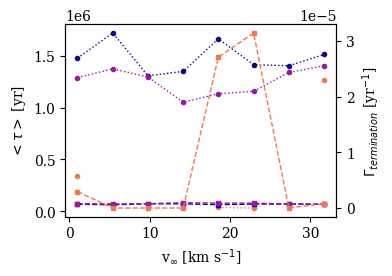

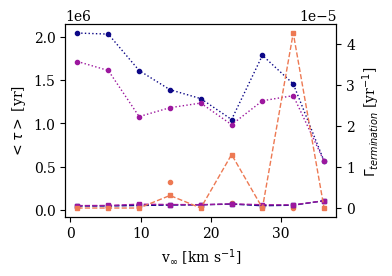

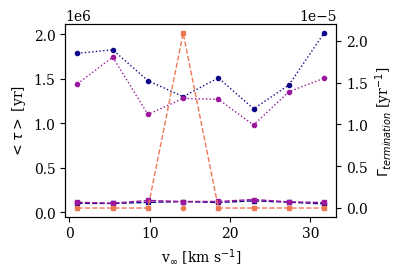

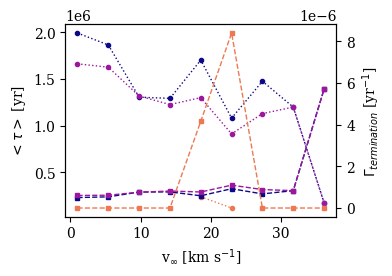

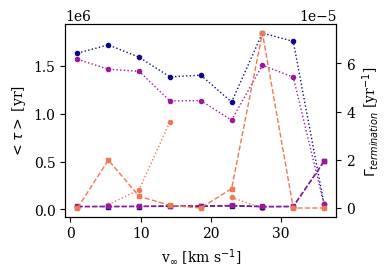

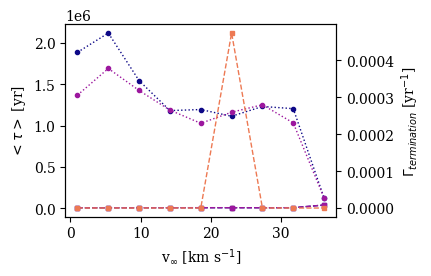

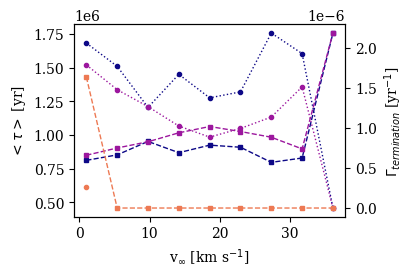

In [20]:
for run in runs_dict.keys():
    analysis = runs_dict[run]['analysis']
    name = analysis.name
    plotobj = pl.Plots(name=name, analysis=[analysis])
    mlist1 = ['total_rate','ejection_rate','collision_rate']
    mlabels1 = ['Total', 'Ejected', 'Collided']
    mylabel1 =r'$\Gamma_{termination}$ [yr$^{-1}$]'
    mlist3 = ['average_lifetime_total','average_lifetime_ejected','average_lifetime_collided']
    mlabels3 = ['Total', 'Ejected', 'Collided']
    mylabel3 =r'$<\tau>$ [yr]'
    mlists = [mlist3, mlist1]
    mlabels = [mlabels3, mlabels1]
    mylabels = [mylabel3, mylabel1]
    plotobj.plot_metric_wrt_v_twinaxis(metric_lists=mlists, metric_ylabels=mylabels, metric_labels=None, analysis_name=name, save=False)

In [97]:
analysis_list = []
for run in runs_dict.keys():
    analysis = runs_dict[run]['analysis']
    analysis_list.append(analysis)

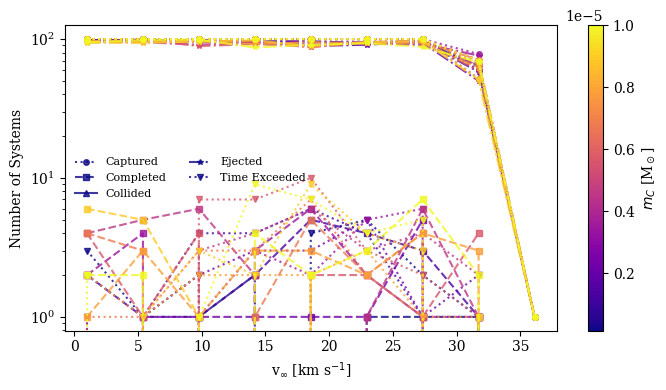

In [98]:
plotobj2 = pl.Plots(name="Combined_Runs", analysis=analysis_list)
metric_list = ['n_captured', 'completed_count', 'collision_count', 'escape_C_count', 'time_exceeded_count']
metric_labels = ['Captured', 'Completed', 'Collided', 'Ejected', 'Time Exceeded']
mylabel = 'Number of Systems'
plotobj2.multiple_analysis_metric_wrt_v(metric_list=metric_list, metric_ylabel=mylabel, metric_labels=metric_labels, analysis_key= 'All', v_key='All', save=True)

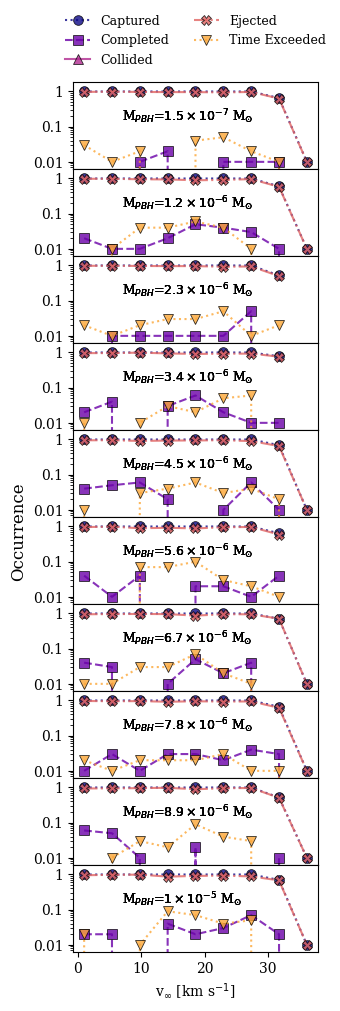

In [101]:
mylabel = 'Occurrence'
plotobj2.multiple_analysis_metric_wrt_v_multipanel(metric_list=metric_list, metric_ylabel=mylabel, metric_labels=metric_labels, analysis_key= 'All', v_key='All', normalize=True, save=True)

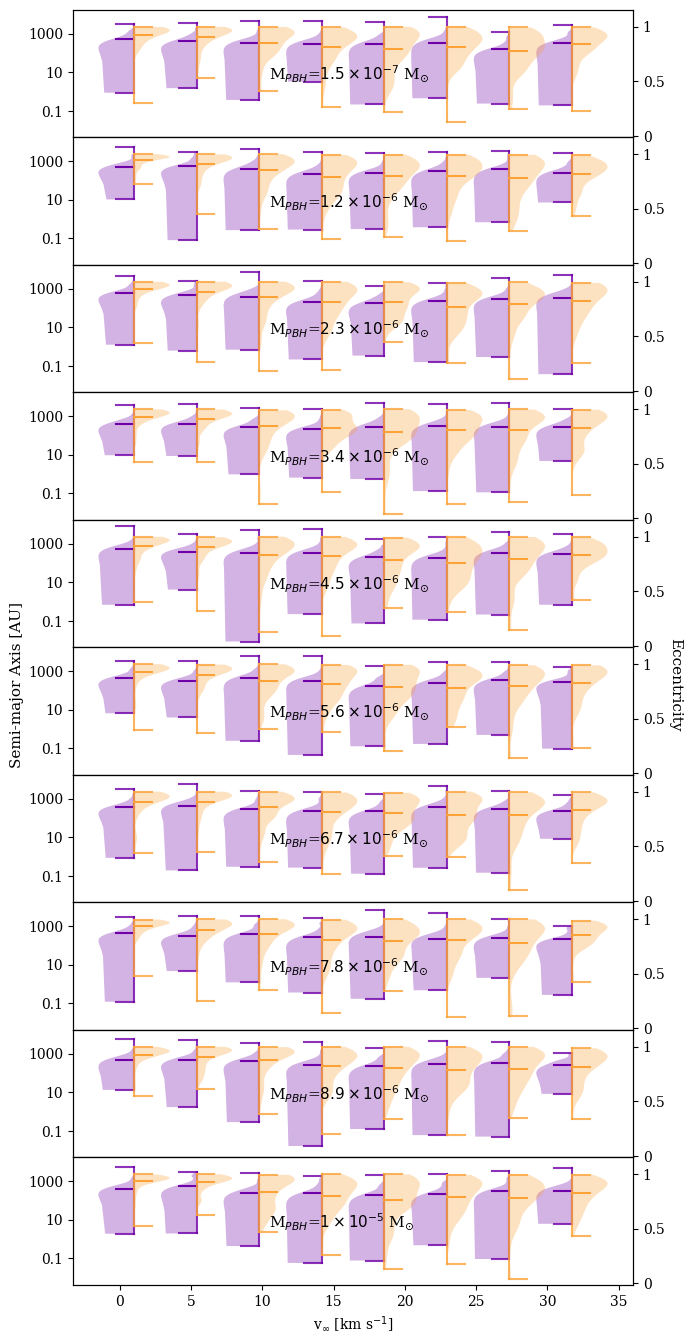

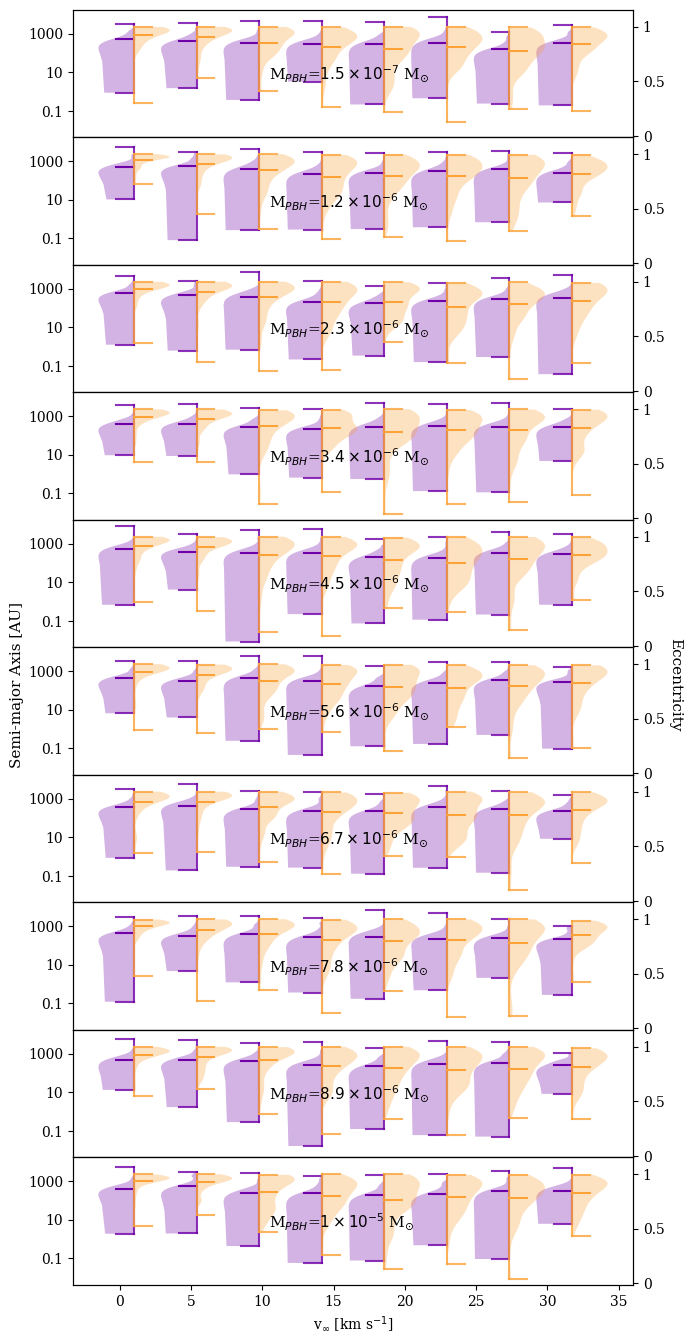

In [133]:
mlist_left = ['semi_major_axes']
mlist_right = ['eccentricities']
mlabels_left = 'Semi-major Axis [AU]'
mlabels_right = 'Eccentricity'

plotobj2.multiple_analysis_metric_array_wrt_v_twinaxis_multipanel(
    metric_lists=[mlist_left, mlist_right],
    metric_ylabels=[mlabels_left, mlabels_right],
    scale=['log','linear'],
    analysis_key='All',
    v_key='All',
    save=True
)

Analysis 'Sun_Jupiter_s1' not found.


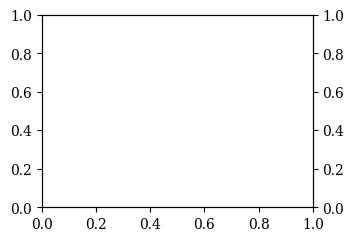

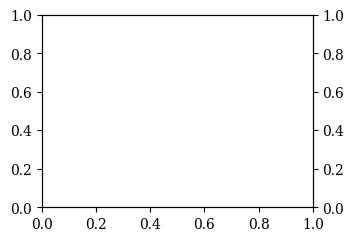

In [90]:
mlist0 = ['capture_cross_section_total','capture_cross_section_ejected','capture_cross_section_collided']
mlabels0 = ['Total', 'Ejected', 'Collided']
mylabel0 = r'$\sigma_{capture}$ [AU$^2$]'
mlist2 = ['total_systems_neq','ejected_systems_neq','collided_systems_neq']
mlabels2 = ['Total', 'Ejected', 'Collided']
mylabel2 =r'N$_{eq}$ [AU$^3$]'
mlists = [mlist0, mlist2]
mlabels = [mlabels0, mlabels2]
mylabels = [mylabel0, mylabel2]
plotobj.plot_metric_wrt_v_twinaxis(metric_lists=mlists, metric_ylabels=mylabels, metric_labels=None, analysis_name=name_s1, save=False)